# Домашнее задание 3

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Прежде всего импортируем библиотеки необходимые для решения поставленной задачи:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

Проверка на наличие видеокарты:

In [2]:
print(f"Поддерживается ли CUDA : {torch.cuda.is_available()}")
print(f'Количество гпу девайсов: {torch.cuda.device_count()}')
print(f"Характеристики видеокарты : {torch.cuda.get_device_properties(0)}")

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Поддерживается ли CUDA : True
Количество гпу девайсов: 1
Характеристики видеокарты : _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)
cuda:0


Посмотрим на общие характеристки датасета, с которым будет в дальнейшем работать.

In [3]:
dataset = fetch_california_housing(return_X_y=False)

df = pd.DataFrame(dataset['data'])
df['target'] = dataset['target']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20640 non-null  float64
 1   1       20640 non-null  float64
 2   2       20640 non-null  float64
 3   3       20640 non-null  float64
 4   4       20640 non-null  float64
 5   5       20640 non-null  float64
 6   6       20640 non-null  float64
 7   7       20640 non-null  float64
 8   target  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Как видим все признаки имеют вещественный тип, то есть не нужно производить предобработку текстовых или категориальных данных. Кроме того можно заметить, что нет пропусков, то есть можно проигнорировать методы их заполнения. Теперь создадим класс для загрузки и предобработки датасета:

In [4]:
class CaliforniaHousingDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        X, y = fetch_california_housing(return_X_y=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            random_state=13, 
                                                            test_size=0.25)

        if train:
          self.data = X_train
          self.labels = y_train
        else:
          self.data = X_test
          self.labels = y_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index, :], self.labels[index]

Создадим даталоадер для удобной подачи данных в процессе обучения и тестирования.

In [5]:
train_dataset = CaliforniaHousingDataset()
test_dataset = CaliforniaHousingDataset(train=False)


train_data_loader = torch.utils.data.DataLoader(train_dataset, 
                                                batch_size=32, 
                                                shuffle=True, 
                                                num_workers=1)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=8,
                                               num_workers=1)

Теперь напишем сеть, которая будет предсказывать цену недвижимости на основе имеющихся параметров.

In [6]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu", device=None):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim, device=device)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return torch.sigmoid(x)
        if self.activation == "elu":
            return F.elu(x)
        if self.activation == "tanh":
            return torch.tanh(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, device):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_dim, device=device)
        self.fc1 = Perceptron(input_dim, hidden_dim, 'sigmoid', device=device)
        self.bn2 = nn.BatchNorm1d(hidden_dim, device=device)
        self.dp1 = nn.Dropout(0.2)
        # self.fc1 = Perceptron(input_dim, 2 * hidden_dim, 'sigmoid', device=device)
        # self.bn2 = nn.BatchNorm1d(2 * hidden_dim, device=device)
        # self.dp1 = nn.Dropout(0.2)
        # self.fc2 = Perceptron(2 * hidden_dim, hidden_dim, device=device)
        # self.bn3 = nn.BatchNorm1d(hidden_dim, device=device)
        # self.dp2 = nn.Dropout(0.1)
        self.fc3 = Perceptron(hidden_dim, 1, activation='relu', device=device)
        self.double()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.dp1(x)
        # x = self.fc2(x)
        # x = self.bn3(x)
        # x = self.dp2(x)
        x = self.fc3(x)
        return x

В качестве критерия оценки качества нашей сети будет использовать среднеквадратичную ошибку. Воспользуемся перебором по сетке для определения оптимальных гиперпараметров, кроме того это позволит сравнить скорость сходимости разных оптимизаторов.

In [7]:
criterion = nn.MSELoss()


learning_rate = [1e-2, 1e-3, 1e-4]
epochs = [5, 10, 15]

In [8]:
for num_epochs in epochs:
  for lr in learning_rate:

    ff = FeedForward(8, 10, device=device)
    optimizer = optim.Adam(ff.parameters(), lr=lr)
    # train_losses = []
    # test_losses = []

    for epoch in range(num_epochs):
        running_loss, running_items = 0.0, 0.0
        ff.train()

        for i, data in enumerate(train_data_loader):
            inputs, labels = torch.DoubleTensor(data[0]).to(device), \
                              torch.DoubleTensor(data[1]).to(device)
            

            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = ff(inputs)
            # Рассчитываем лосс-функцию
            loss = criterion(outputs.squeeze(), labels)
            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            if i % 100 == 0:
                ff.eval()
                test_running_loss, test_running_total = 0.0, 0.0
                for j, data in enumerate(test_data_loader):
                    test_inputs, test_labels = \
                      torch.DoubleTensor(data[0]).to(device), \
                      torch.DoubleTensor(data[1]).to(device)
                
                    test_outputs = ff(test_inputs)
                    test_running_total += len(test_labels)
                    test_loss = criterion(test_outputs.squeeze(), test_labels)
                    test_running_loss += test_loss.item()
                
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f} ' \
                      f'Test loss: {test_running_loss / test_running_total:.3f}')
                
                # train_losses.append(running_loss / running_items)
                # test_losses.append(test_running_loss / test_running_total)

    print('Training is finished!')

Epoch [1/5]. Step [1/484]. Loss: 0.153 Test loss: 0.707
Epoch [1/5]. Step [101/484]. Loss: 0.177 Test loss: 0.707
Epoch [1/5]. Step [201/484]. Loss: 0.175 Test loss: 0.707
Epoch [1/5]. Step [301/484]. Loss: 0.161 Test loss: 0.166
Epoch [1/5]. Step [401/484]. Loss: 0.127 Test loss: 0.072
Epoch [2/5]. Step [1/484]. Loss: 0.138 Test loss: 0.094
Epoch [2/5]. Step [101/484]. Loss: 0.017 Test loss: 0.065
Epoch [2/5]. Step [201/484]. Loss: 0.017 Test loss: 0.072
Epoch [2/5]. Step [301/484]. Loss: 0.017 Test loss: 0.074
Epoch [2/5]. Step [401/484]. Loss: 0.017 Test loss: 0.067
Epoch [3/5]. Step [1/484]. Loss: 0.167 Test loss: 0.062
Epoch [3/5]. Step [101/484]. Loss: 0.016 Test loss: 0.064
Epoch [3/5]. Step [201/484]. Loss: 0.016 Test loss: 0.060
Epoch [3/5]. Step [301/484]. Loss: 0.016 Test loss: 0.062
Epoch [3/5]. Step [401/484]. Loss: 0.016 Test loss: 0.068
Epoch [4/5]. Step [1/484]. Loss: 0.112 Test loss: 0.058
Epoch [4/5]. Step [101/484]. Loss: 0.016 Test loss: 0.060
Epoch [4/5]. Step [201

В большинство случаев довольно быстро наступает переобучение сети. Однако при маленькой стартовой скорости обучения модель наоборот практически не обучается. Теперь попробуем использовать стохастический градиент в качестве оптимизатора.

In [15]:
for num_epochs in epochs:
  for lr in learning_rate:

    ff = FeedForward(8, 10, device=device)
    optimizer = optim.SGD(ff.parameters(), lr=lr)
    # train_losses = []
    # test_losses = []

    for epoch in range(num_epochs):
        running_loss, running_items = 0.0, 0.0
        ff.train()

        for i, data in enumerate(train_data_loader):
            inputs, labels = torch.DoubleTensor(data[0]).to(device), \
                              torch.DoubleTensor(data[1]).to(device)
            

            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = ff(inputs)
            # Рассчитываем лосс-функцию
            loss = criterion(outputs.squeeze(), labels)
            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            if i % 100 == 0:
                ff.eval()
                test_running_loss, test_running_total = 0.0, 0.0
                for j, data in enumerate(test_data_loader):
                    test_inputs, test_labels = \
                      torch.DoubleTensor(data[0]).to(device), \
                      torch.DoubleTensor(data[1]).to(device)
                
                    test_outputs = ff(test_inputs)
                    test_running_total += len(test_labels)
                    test_loss = criterion(test_outputs.squeeze(), test_labels)
                    test_running_loss += test_loss.item()
                
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f} ' \
                      f'Test loss: {test_running_loss / test_running_total:.3f}')
                
                # train_losses.append(running_loss / running_items)
                # test_losses.append(test_running_loss / test_running_total)

    print('Training is finished!')

Epoch [1/5]. Step [1/484]. Loss: 0.188 Test loss: 0.707
Epoch [1/5]. Step [101/484]. Loss: 0.169 Test loss: 0.707
Epoch [1/5]. Step [201/484]. Loss: 0.173 Test loss: 0.707
Epoch [1/5]. Step [301/484]. Loss: 0.174 Test loss: 0.707
Epoch [1/5]. Step [401/484]. Loss: 0.174 Test loss: 0.707
Epoch [2/5]. Step [1/484]. Loss: 0.166 Test loss: 0.707
Epoch [2/5]. Step [101/484]. Loss: 0.180 Test loss: 0.707
Epoch [2/5]. Step [201/484]. Loss: 0.179 Test loss: 0.707
Epoch [2/5]. Step [301/484]. Loss: 0.177 Test loss: 0.707
Epoch [2/5]. Step [401/484]. Loss: 0.176 Test loss: 0.707
Epoch [3/5]. Step [1/484]. Loss: 0.161 Test loss: 0.707
Epoch [3/5]. Step [101/484]. Loss: 0.175 Test loss: 0.707
Epoch [3/5]. Step [201/484]. Loss: 0.172 Test loss: 0.707
Epoch [3/5]. Step [301/484]. Loss: 0.176 Test loss: 0.707
Epoch [3/5]. Step [401/484]. Loss: 0.175 Test loss: 0.707
Epoch [4/5]. Step [1/484]. Loss: 0.118 Test loss: 0.707
Epoch [4/5]. Step [101/484]. Loss: 0.172 Test loss: 0.707
Epoch [4/5]. Step [201

Результаты сравнимые с полученными при использовании Adam наблюдаются при довольно большой скорости обучения - 1e-2. Также можно заметить, что модель сходится медленнее, нужно как минимум 10 эпох. Наконец попробуем RMSprop в качестве оптимизатора.

In [16]:
for num_epochs in epochs:
  for lr in learning_rate:

    ff = FeedForward(8, 10, device=device)
    optimizer = optim.RMSprop(ff.parameters(), lr=lr)
    # train_losses = []
    # test_losses = []

    for epoch in range(num_epochs):
        running_loss, running_items = 0.0, 0.0
        ff.train()

        for i, data in enumerate(train_data_loader):
            inputs, labels = torch.DoubleTensor(data[0]).to(device), \
                              torch.DoubleTensor(data[1]).to(device)
            

            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = ff(inputs)
            # Рассчитываем лосс-функцию
            loss = criterion(outputs.squeeze(), labels)
            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            if i % 100 == 0:
                ff.eval()
                test_running_loss, test_running_total = 0.0, 0.0
                for j, data in enumerate(test_data_loader):
                    test_inputs, test_labels = \
                      torch.DoubleTensor(data[0]).to(device), \
                      torch.DoubleTensor(data[1]).to(device)
                
                    test_outputs = ff(test_inputs)
                    test_running_total += len(test_labels)
                    test_loss = criterion(test_outputs.squeeze(), test_labels)
                    test_running_loss += test_loss.item()
                
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f} ' \
                      f'Test loss: {test_running_loss / test_running_total:.3f}')
                
                # train_losses.append(running_loss / running_items)
                # test_losses.append(test_running_loss / test_running_total)

    print('Training is finished!')

Epoch [1/5]. Step [1/484]. Loss: 0.134 Test loss: 0.265
Epoch [1/5]. Step [101/484]. Loss: 0.043 Test loss: 0.171
Epoch [1/5]. Step [201/484]. Loss: 0.042 Test loss: 0.169
Epoch [1/5]. Step [301/484]. Loss: 0.042 Test loss: 0.169
Epoch [1/5]. Step [401/484]. Loss: 0.042 Test loss: 0.169
Epoch [2/5]. Step [1/484]. Loss: 0.128 Test loss: 0.167
Epoch [2/5]. Step [101/484]. Loss: 0.046 Test loss: 0.172
Epoch [2/5]. Step [201/484]. Loss: 0.042 Test loss: 0.115
Epoch [2/5]. Step [301/484]. Loss: 0.036 Test loss: 0.084
Epoch [2/5]. Step [401/484]. Loss: 0.032 Test loss: 0.069
Epoch [3/5]. Step [1/484]. Loss: 0.171 Test loss: 0.077
Epoch [3/5]. Step [101/484]. Loss: 0.018 Test loss: 0.062
Epoch [3/5]. Step [201/484]. Loss: 0.018 Test loss: 0.061
Epoch [3/5]. Step [301/484]. Loss: 0.017 Test loss: 0.065
Epoch [3/5]. Step [401/484]. Loss: 0.017 Test loss: 0.062
Epoch [4/5]. Step [1/484]. Loss: 0.115 Test loss: 0.063
Epoch [4/5]. Step [101/484]. Loss: 0.016 Test loss: 0.060
Epoch [4/5]. Step [201

В большинстве случаев также можно наблюдать переобучение. Лучших результатов удается добиться на 15 эпохах и скорости обучения 1e-2. Теперь зафиксируем параметры и посмотрим на скорость сходимости при использовании разных оптимизаторов.

In [17]:
ff = FeedForward(8, 10, device=device)
optimizer = optim.Adam(ff.parameters(), lr=1e-3)
num_epochs = 15
train_losses_adam = []
test_losses_adam = []

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    ff.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = torch.DoubleTensor(data[0]).to(device), \
                          torch.DoubleTensor(data[1]).to(device)
        

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = ff(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs.squeeze(), labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 100 == 0:
            ff.eval()
            test_running_loss, test_running_total = 0.0, 0.0
            for j, data in enumerate(test_data_loader):
                test_inputs, test_labels = \
                  torch.DoubleTensor(data[0]).to(device), \
                  torch.DoubleTensor(data[1]).to(device)
            
                test_outputs = ff(test_inputs)
                test_running_total += len(test_labels)
                test_loss = criterion(test_outputs.squeeze(), test_labels)
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f} ' \
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            train_losses_adam.append(running_loss / running_items)
            test_losses_adam.append(test_running_loss / test_running_total)

print('Training is finished!')

Epoch [1/15]. Step [1/484]. Loss: 0.150 Test loss: 0.606
Epoch [1/15]. Step [101/484]. Loss: 0.088 Test loss: 0.210
Epoch [1/15]. Step [201/484]. Loss: 0.066 Test loss: 0.170
Epoch [1/15]. Step [301/484]. Loss: 0.058 Test loss: 0.169
Epoch [1/15]. Step [401/484]. Loss: 0.054 Test loss: 0.169
Epoch [2/15]. Step [1/484]. Loss: 0.094 Test loss: 0.169
Epoch [2/15]. Step [101/484]. Loss: 0.043 Test loss: 0.169
Epoch [2/15]. Step [201/484]. Loss: 0.041 Test loss: 0.164
Epoch [2/15]. Step [301/484]. Loss: 0.041 Test loss: 0.145
Epoch [2/15]. Step [401/484]. Loss: 0.038 Test loss: 0.116
Epoch [3/15]. Step [1/484]. Loss: 0.061 Test loss: 0.093
Epoch [3/15]. Step [101/484]. Loss: 0.021 Test loss: 0.079
Epoch [3/15]. Step [201/484]. Loss: 0.020 Test loss: 0.074
Epoch [3/15]. Step [301/484]. Loss: 0.019 Test loss: 0.068
Epoch [3/15]. Step [401/484]. Loss: 0.019 Test loss: 0.065
Epoch [4/15]. Step [1/484]. Loss: 0.129 Test loss: 0.063
Epoch [4/15]. Step [101/484]. Loss: 0.017 Test loss: 0.062
Epoch

In [18]:
ff = FeedForward(8, 10, device=device)
optimizer = optim.SGD(ff.parameters(), lr=1e-3)
num_epochs = 15
train_losses_sgd = []
test_losses_sgd = []

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    ff.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = torch.DoubleTensor(data[0]).to(device), \
                          torch.DoubleTensor(data[1]).to(device)
        

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = ff(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs.squeeze(), labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 100 == 0:
            ff.eval()
            test_running_loss, test_running_total = 0.0, 0.0
            for j, data in enumerate(test_data_loader):
                test_inputs, test_labels = \
                  torch.DoubleTensor(data[0]).to(device), \
                  torch.DoubleTensor(data[1]).to(device)
            
                test_outputs = ff(test_inputs)
                test_running_total += len(test_labels)
                test_loss = criterion(test_outputs.squeeze(), test_labels)
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f} ' \
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            train_losses_sgd.append(running_loss / running_items)
            test_losses_sgd.append(test_running_loss / test_running_total)

print('Training is finished!')

Epoch [1/15]. Step [1/484]. Loss: 0.134 Test loss: 0.707
Epoch [1/15]. Step [101/484]. Loss: 0.172 Test loss: 0.707
Epoch [1/15]. Step [201/484]. Loss: 0.175 Test loss: 0.707
Epoch [1/15]. Step [301/484]. Loss: 0.176 Test loss: 0.707
Epoch [1/15]. Step [401/484]. Loss: 0.174 Test loss: 0.707
Epoch [2/15]. Step [1/484]. Loss: 0.164 Test loss: 0.707
Epoch [2/15]. Step [101/484]. Loss: 0.172 Test loss: 0.707
Epoch [2/15]. Step [201/484]. Loss: 0.175 Test loss: 0.707
Epoch [2/15]. Step [301/484]. Loss: 0.174 Test loss: 0.707
Epoch [2/15]. Step [401/484]. Loss: 0.175 Test loss: 0.707
Epoch [3/15]. Step [1/484]. Loss: 0.185 Test loss: 0.707
Epoch [3/15]. Step [101/484]. Loss: 0.174 Test loss: 0.707
Epoch [3/15]. Step [201/484]. Loss: 0.177 Test loss: 0.707
Epoch [3/15]. Step [301/484]. Loss: 0.176 Test loss: 0.707
Epoch [3/15]. Step [401/484]. Loss: 0.174 Test loss: 0.707
Epoch [4/15]. Step [1/484]. Loss: 0.116 Test loss: 0.707
Epoch [4/15]. Step [101/484]. Loss: 0.174 Test loss: 0.707
Epoch

In [19]:
ff = FeedForward(8, 10, device=device)
optimizer = optim.RMSprop(ff.parameters(), lr=1e-3)
num_epochs = 15
train_losses_rmsprop = []
test_losses_rmsprop = []

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0
    ff.train()

    for i, data in enumerate(train_data_loader):
        inputs, labels = torch.DoubleTensor(data[0]).to(device), \
                          torch.DoubleTensor(data[1]).to(device)
        

        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = ff(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs.squeeze(), labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 100 == 0:
            ff.eval()
            test_running_loss, test_running_total = 0.0, 0.0
            for j, data in enumerate(test_data_loader):
                test_inputs, test_labels = \
                  torch.DoubleTensor(data[0]).to(device), \
                  torch.DoubleTensor(data[1]).to(device)
            
                test_outputs = ff(test_inputs)
                test_running_total += len(test_labels)
                test_loss = criterion(test_outputs.squeeze(), test_labels)
                test_running_loss += test_loss.item()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_data_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f} ' \
                  f'Test loss: {test_running_loss / test_running_total:.3f}')
            
            train_losses_rmsprop.append(running_loss / running_items)
            test_losses_rmsprop.append(test_running_loss / test_running_total)

print('Training is finished!')

Epoch [1/15]. Step [1/484]. Loss: 0.174 Test loss: 0.506
Epoch [1/15]. Step [101/484]. Loss: 0.049 Test loss: 0.164
Epoch [1/15]. Step [201/484]. Loss: 0.043 Test loss: 0.140
Epoch [1/15]. Step [301/484]. Loss: 0.040 Test loss: 0.115
Epoch [1/15]. Step [401/484]. Loss: 0.036 Test loss: 0.101
Epoch [2/15]. Step [1/484]. Loss: 0.073 Test loss: 0.090
Epoch [2/15]. Step [101/484]. Loss: 0.021 Test loss: 0.083
Epoch [2/15]. Step [201/484]. Loss: 0.020 Test loss: 0.078
Epoch [2/15]. Step [301/484]. Loss: 0.020 Test loss: 0.075
Epoch [2/15]. Step [401/484]. Loss: 0.020 Test loss: 0.071
Epoch [3/15]. Step [1/484]. Loss: 0.170 Test loss: 0.068
Epoch [3/15]. Step [101/484]. Loss: 0.018 Test loss: 0.068
Epoch [3/15]. Step [201/484]. Loss: 0.017 Test loss: 0.066
Epoch [3/15]. Step [301/484]. Loss: 0.017 Test loss: 0.064
Epoch [3/15]. Step [401/484]. Loss: 0.017 Test loss: 0.063
Epoch [4/15]. Step [1/484]. Loss: 0.140 Test loss: 0.062
Epoch [4/15]. Step [101/484]. Loss: 0.016 Test loss: 0.062
Epoch

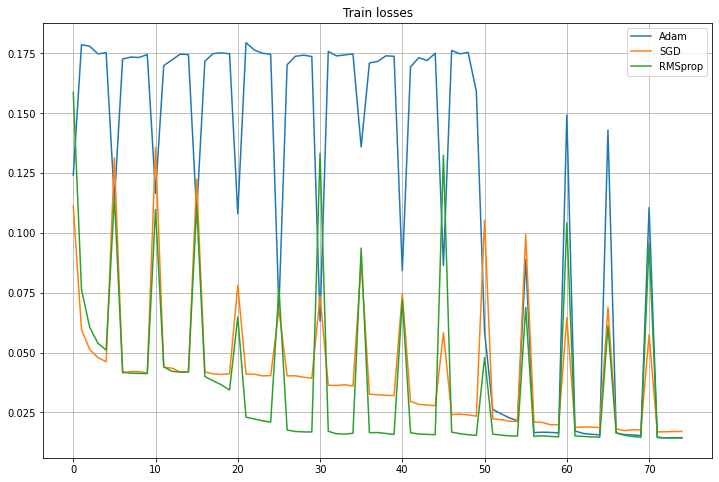

In [14]:
plt.figure(figsize=(12,8))
plt.title('Train losses')
plt.plot(train_losses_adam, label='Adam')
plt.plot(train_losses_sgd, label='SGD')
plt.plot(train_losses_rmsprop, label='RMSprop')
plt.grid()
plt.legend();

Ошибки на трейне ведут себя достаточно нервно, видны значительные колебания, отчасти это связано с тем в выборку попадают расчеты, сделанные в каждой эпохе, на основе обучения 1 батча. Они делают график таким "зубчатым".

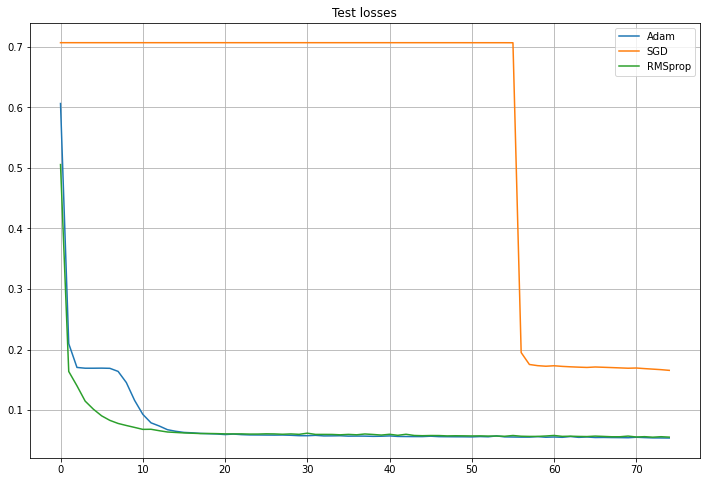

In [20]:
plt.figure(figsize=(12,8))
plt.title('Test losses')
plt.plot(test_losses_adam, label='Adam')
plt.plot(test_losses_sgd, label='SGD')
plt.plot(test_losses_rmsprop, label='RMSprop')
plt.grid()
plt.legend();

Ошибки на тесте меняются более равномерно. Видим, что быстрее всего сходится в данном случае модель с оптимизатором RMSProp. Почти также быстро сходится Adam. Медленее всего при выбранных гиперпараметрах сходится SGD. Ошибки на тесте при использовании оптимизаторов RMSProp и Adam довольно быстро перестают значительно меняться, а значит можно значительно сократить количество эпох обучения без значительного ухудшения качества модели.